# Sparkify Project Workspace
We want to predict if a person would leave the app based on the behaviour data. This notebook is used as a playground for a small subset (128MB) of the full dataset available. The goal is deploy the model on the cloud using IBM Watson Studio. 

In [19]:
# import libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql.types import *


from pyspark.ml.feature import VectorAssembler, StandardScaler
#from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate() # create a new one if not existed

# Load and Clean Dataset
The small-dataset file,`mini_sparkify_event_data.json`, is loaded and cleaned. We check for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
### load
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

In [4]:
### check number of records
df.count()

286500

In [5]:
### check variables
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
### since we are dealing with small data set
### use pandas (in memoery) to check the data
user_log = df.toPandas()

In [5]:
### peak on the data
user_log.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1349b4c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa135d75c50>]], dtype=object)

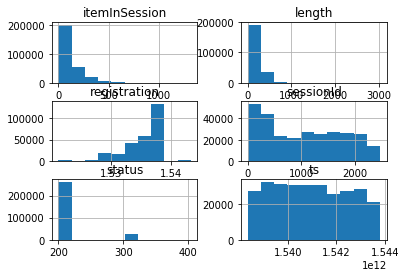

In [13]:
### the distribution of continuous variables
user_log.hist()

In [68]:
### the distribution of discrete variables
for col in [ 'auth', 'gender', 'level', 'method', 'page']:
    print('\n',col)
    print(user_log[col].value_counts())


 auth
Logged In     278102
Logged Out      8249
Guest             97
Cancelled         52
Name: auth, dtype: int64

 gender
F    154578
M    123576
Name: gender, dtype: int64

 level
paid    228162
free     58338
Name: level, dtype: int64

 method
PUT    261064
GET     25436
Name: method, dtype: int64

 page
NextSong                     228108
Home                          14457
Thumbs Up                     12551
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Login                          3241
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Help                           1726
Settings                       1514
About                           924
Upgrade                         499
Save Settings                   310
Error                           258
Submit Upgrade                  159
Submit Downgrade                 63
Cancel                           52
Cance

In [24]:
### check the missing values
user_log.isnull().sum().sort_values()

userId               0
auth                 0
ts                   0
status               0
itemInSession        0
sessionId            0
level                0
page                 0
method               0
registration      8346
location          8346
lastName          8346
gender            8346
firstName         8346
userAgent         8346
length           58392
song             58392
artist           58392
dtype: int64

In [32]:
### check the 'page' of those records without artist info
user_log[~user_log.artist.isnull()]['page'].value_counts()

NextSong    228108
Name: page, dtype: int64

In [6]:
### check userId of ''
user_log['userId'].value_counts().head()

39        9632
          8346
92        7230
140       6880
300011    5732
Name: userId, dtype: int64

- We can see that the missing of userAgent, gender, Name, Location are from users not registering. This is consistent with the number of userID as empty strings (also 8346 items). 
- The missing of artist and song information comes from the pages of 'NextSong'.

In [28]:
# unique IDs
user_log['userId'].nunique()

226

In [44]:
user_log[user_log.userId == '']['page'].value_counts()

Home                   4375
Login                  3241
About                   429
Help                    272
Register                 18
Error                     6
Submit Registration       5
Name: page, dtype: int64

The users with the empty string user id may represent users who have not signed up yet or who are signed out and are about to log in.

In [7]:
### delete empty userIds
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df = df.filter(df.userId != '')

### delete useless/sensitve information
### i.e. songs, names
df = df.select('auth', 'gender', 'itemInSession',\
     'level', 'location', 'method', 'page', 'registration',\
       'sessionId', 'status', 'ts', 'userAgent', 'userId')

In [8]:
### change time format
time_format = F.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
df = df.withColumn('time', time_format(df.ts))

In [9]:
df.persist()

DataFrame[auth: string, gender: string, itemInSession: bigint, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, status: bigint, ts: bigint, userAgent: string, userId: string, time: string]

# Exploratory Data Analysis
Before working with the full dataset, we perform EDA by loading a small subset of the data and doing basic manipulations within Spark.

## Define Churn
A column `Churn` is created as the label for the predictor. For this project, the `Cancellation Confirmation` events are used to define churn, which happen for both paid and free users. Later, we might also look into the `Downgrade` events.

In [10]:
### Users cancelled their accounts
flag_cancel_event = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

df = df.withColumn('cancel', flag_cancel_event('page'))

windowval = Window.partitionBy('userId').orderBy(F.desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

### Create the column churn
df = df.withColumn('churn', F.sum('cancel').over(windowval))

In [78]:
### randomly check a user who churned
df.select(['userId', 'time', 'page', 'level', 'churn', 'cancel']).where(df.userId == '121').sort('time').collect()

[Row(userId='121', time='2018-10-02 13:54:47', page='Home', level='free', churn=1, cancel=0),
 Row(userId='121', time='2018-10-02 13:55:37', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='121', time='2018-10-02 13:57:44', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='121', time='2018-10-02 14:01:30', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='121', time='2018-10-02 14:01:31', page='Thumbs Up', level='free', churn=1, cancel=0),
 Row(userId='121', time='2018-10-02 14:02:32', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='121', time='2018-10-02 14:06:21', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='121', time='2018-10-02 14:11:15', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='121', time='2018-10-02 14:11:16', page='Thumbs Up', level='free', churn=1, cancel=0),
 Row(userId='121', time='2018-10-02 14:20:46', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='121', tim

## Explore Data
Compare the behavior for users who stayed vs users who churned. We start by exploring aggregates on these two groups of users.
### Time

In [95]:
# time
df.agg(F.min('time'),F.max('time')).show()

+-------------------+-------------------+
|          min(time)|          max(time)|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-12-03 01:11:16|
+-------------------+-------------------+



The time duration of the data is about two months.
### Gender

In [85]:
# Gender
df.select('userId', 'gender', 'churn') \
    .dropDuplicates() \
    .groupby(['churn', 'gender'])\
    .count().sort(['churn', 'gender']).show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    0|     M|   89|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



It seems a higher percentage of male to churn.
### Levels

In [101]:
# Level related to churn?
df.where(df.churn==1).select('userId', 'level') \
    .dropDuplicates() \
    .groupby(['userId'])\
    .count()\
    .show() 

+------+-----+
|userId|count|
+------+-----+
|   125|    1|
|    51|    1|
|    54|    2|
|100014|    1|
|   101|    2|
|100021|    1|
|    29|    2|
|    73|    2|
|    87|    2|
|     3|    1|
|    28|    2|
|100022|    1|
|100025|    2|
|300007|    1|
|100006|    1|
|    18|    1|
|    70|    2|
|100005|    1|
|    17|    2|
|100007|    1|
+------+-----+
only showing top 20 rows



In [105]:
df.select(['userId', 'time', 'page', 'level', 'churn', 'cancel']).where((df.userId == '54' )& (df.level!='paid'))\
.sort('time').collect()

[Row(userId='54', time='2018-10-15 12:54:34', page='Home', level='free', churn=1, cancel=0),
 Row(userId='54', time='2018-10-15 12:57:53', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='54', time='2018-10-15 13:01:10', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='54', time='2018-10-15 13:02:13', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='54', time='2018-10-15 13:05:44', page='Roll Advert', level='free', churn=1, cancel=0),
 Row(userId='54', time='2018-10-15 13:06:13', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='54', time='2018-10-15 13:09:06', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='54', time='2018-10-15 13:14:15', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='54', time='2018-10-15 13:19:26', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='54', time='2018-10-15 13:22:41', page='NextSong', level='free', churn=1, cancel=0),
 Row(userId='54', time='2018-10

In [106]:
df.select(['userId', 'time', 'page', 'level', 'churn', 'cancel']).where((df.userId == '54' )& (df.level=='paid'))\
.sort('time').collect()

[Row(userId='54', time='2018-10-01 00:32:10', page='NextSong', level='paid', churn=1, cancel=0),
 Row(userId='54', time='2018-10-01 00:36:20', page='NextSong', level='paid', churn=1, cancel=0),
 Row(userId='54', time='2018-10-01 00:39:56', page='NextSong', level='paid', churn=1, cancel=0),
 Row(userId='54', time='2018-10-01 00:45:39', page='NextSong', level='paid', churn=1, cancel=0),
 Row(userId='54', time='2018-10-01 00:45:49', page='Downgrade', level='paid', churn=1, cancel=0),
 Row(userId='54', time='2018-10-01 00:49:45', page='NextSong', level='paid', churn=1, cancel=0),
 Row(userId='54', time='2018-10-01 00:54:14', page='NextSong', level='paid', churn=1, cancel=0),
 Row(userId='54', time='2018-10-01 00:54:15', page='Thumbs Up', level='paid', churn=1, cancel=0),
 Row(userId='54', time='2018-10-01 12:12:37', page='NextSong', level='paid', churn=1, cancel=0),
 Row(userId='54', time='2018-10-01 12:17:44', page='NextSong', level='paid', churn=1, cancel=0),
 Row(userId='54', time='2018

The levels are not particularly related to churned users.
### Use Frequency: based on sessions

In [11]:
user_log = df.toPandas()
churned = user_log[user_log.churn==1]
unchurned = user_log[user_log.churn==0]

In [21]:
def frequency_of_session(df):
    '''
    Calculate the number of sessions per day
    '''
    df = df.groupby('userId').agg({'ts': 'max',\
                                        'registration': 'max',\
                                        'sessionId':'count'})

    df = df['sessionId'] \
    /(df['ts']-df['registration'])*(1000*60*60*24)

    plt.hist(df)

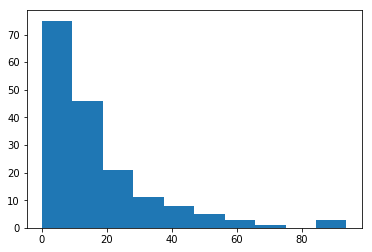

In [23]:
frequency_of_session(unchurned)

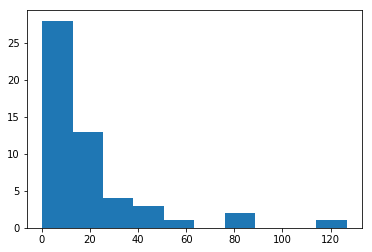

In [22]:
frequency_of_session(churned)

Unchurned users have more sessions per day
###  number of songs between visiting the home page


In [75]:
def songs_btw_homes(df):
    '''
    Calculate the number of songs users listen to 
    on average between visiting the home page
    '''
    df = df[(df.page == 'NextSong') | (df.page == 'Home')][['userId', 'page', 'ts']]
    df['homevisit'] = (df['page'] == 'Home').astype(int)
    
    ### rolling window
    df['period'] = df.groupby('userId')['homevisit'].transform(lambda x: x.expanding(1).sum())
    
    df = df[df.page=='NextSong'].groupby(['userId', 'period'])['page'].count()

    df = pd.DataFrame(df)

    df.groupby('userId')['page'].mean().hist()

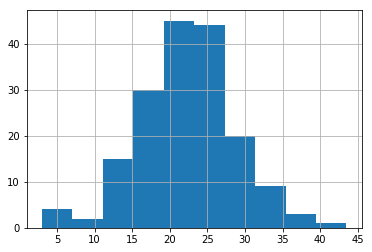

In [76]:
songs_btw_homes(unchurned)

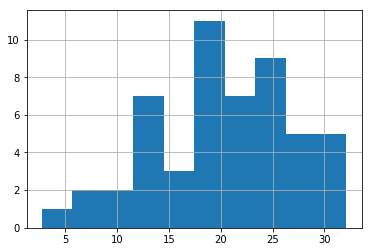

In [77]:
songs_btw_homes(churned)

The unchurned users listen to more songs between visiting homepages
### time per session

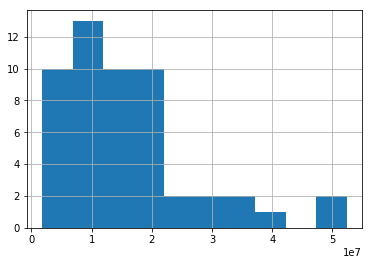

In [82]:
# time per session
def time_per_session(df):
    '''
    Calculate average time spent per session
    '''
    df_time = df.groupby(["userId", "sessionId"])\
    .agg({'ts': lambda x:max(x) - min(x)})
    
    df_time.groupby("userId")['ts'].mean().hist()

time_per_session(churned)

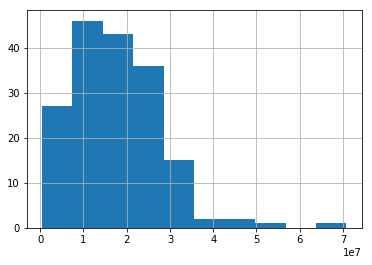

In [83]:
time_per_session(unchurned)

Unchurned users spent longer time in each sessions

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [112]:
### Use Frequency: based on sessions
df_freq = df.groupby('userId').agg({'ts': 'max',\
                                    'registration': 'max',\
                                    'sessionId':'count'})

df_freq = df_freq.withColumn('days', (F.col('max(ts)') - F.col('max(registration)'))/(1000*60*60*24))\
        .withColumn('freq', F.col('count(sessionId)')/F.col('days'))\
        .select('userId', 'freq')

df_freq.head()

Row(userId='100010', freq=6.847141574652863)

In [113]:
# How many songs do users listen to on average between visiting the home page? 

ifhome = F.udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userId') \
    .orderBy(F.desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userId', 'page', 'ts') \
    .withColumn('homevisit', ifhome(F.col('page'))) \
    .withColumn('period', F.sum('homevisit').over(user_window))

df_songs = cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'})\
    .groupBy('userID') \
    .agg(F.avg('count(period)').alias("Songs"))

df_songs.head()

Row(userID='100010', Songs=22.916666666666668)

In [114]:
# time per session
df_time = df.groupby("userId", "sessionId")\
    .agg((F.max(df.ts)-F.min(df.ts)).alias("duration"))\
    .groupby("userId").agg(F.avg(F.col('duration')).alias("time_session"))

df_time.head()

Row(userId='100010', time_session=9269000.0)

In [115]:
# percentage time in different page type 
time_page_each = df.groupby("userId")\
.pivot('page').agg(F.count('page'))\
.fillna(0)

cols = time_page_each.columns

time_page_total = df.groupby("userId")\
.agg(F.count('page'))

time_page_each = time_page_each.join(time_page_total, ['userId'], how='left')

for col in cols[1:]: # get rid of 'userId' in the cols
    time_page_each =  time_page_each\
        .withColumn(col, F.col(col)/F.col('count(page)'))

df_page = time_page_each.drop('count(page)')

df_page.head()

Row(userId='100010', About=0.0026246719160104987, Add Friend=0.010498687664041995, Add to Playlist=0.01837270341207349, Cancel=0.0, Cancellation Confirmation=0.0, Downgrade=0.0, Error=0.0, Help=0.005249343832020997, Home=0.028871391076115485, Logout=0.013123359580052493, NextSong=0.7217847769028871, Roll Advert=0.13648293963254593, Save Settings=0.0, Settings=0.0, Submit Downgrade=0.0, Submit Upgrade=0.0, Thumbs Down=0.013123359580052493, Thumbs Up=0.04461942257217848, Upgrade=0.005249343832020997)

In [118]:
# gender
df_gender = df.select('userId', 'gender').dropDuplicates()

int_gender = F.udf(lambda x: 1 if x == "F" else 0, IntegerType())

df_gender = df_gender.withColumn('gender', int_gender('gender'))

df_gender.head()

Row(userId='44', gender=1)

In [124]:
# if ever paid
df_level = df.select('userId', 'level').dropDuplicates()

int_level = F.udf(lambda x: 1 if x == "paid" else 0, IntegerType())

df_level = df_level.withColumn('level', int_level('level'))\
    .groupby('userId').agg(F.max('level').alias('if_paid'))

df_level.head()

[Row(userId='200002', if_paid=1),
 Row(userId='100010', if_paid=0),
 Row(userId='125', if_paid=0),
 Row(userId='7', if_paid=0),
 Row(userId='124', if_paid=1)]

# Modeling
Split the full dataset into train amd test sets. Evaluate the accuracy of the Logistic Regression model. Since the churned users are a fairly small subset, F1 score is used as the metric to optimize.

In [129]:
# churn
df_churn = df.select('userId', 'churn').dropDuplicates()

df_churn.head()

Row(userId='100010', churn=0)

In [132]:
### Create full data set
full_data = df_churn
feature_list = [df_freq, df_songs, df_time, df_page, df_gender, df_level]

for f in feature_list:
    full_data = full_data.join(f, ['userId'], how='left')

full_data.head()

Row(userId='100010', churn=0, freq=6.847141574652863, Songs=22.916666666666668, time_session=9269000.0, About=0.0026246719160104987, Add Friend=0.010498687664041995, Add to Playlist=0.01837270341207349, Cancel=0.0, Cancellation Confirmation=0.0, Downgrade=0.0, Error=0.0, Help=0.005249343832020997, Home=0.028871391076115485, Logout=0.013123359580052493, NextSong=0.7217847769028871, Roll Advert=0.13648293963254593, Save Settings=0.0, Settings=0.0, Submit Downgrade=0.0, Submit Upgrade=0.0, Thumbs Down=0.013123359580052493, Thumbs Up=0.04461942257217848, Upgrade=0.005249343832020997, gender=1, if_paid=0)

In [ ]:
# vectorize the features
assembler = VectorAssembler(inputCols=full_data.columns[2:], outputCol="NumFeatures")
full_data = assembler.transform(full_data) 

# standarlize the features
scaler = StandardScaler(inputCol='NumFeatures', outputCol='features', withMean=True, withStd=True)
scalerModel = scaler.fit(full_data)
full_data = scalerModel.transform(full_data)

In [137]:
full_data = full_data.select(F.col('churn').alias("label"), 'features')

full_data.head()

Row(label=0, features=DenseVector([-0.5488, 0.1674, -0.7559, 0.5372, -0.4475, -0.3974, -0.2007, -0.2007, -1.156, -0.6078, 0.0042, -0.6645, 0.001, -1.2659, 3.1136, -0.632, -0.5438, -0.4155, -0.5116, 0.5411, 0.0772, 0.5025, 1.0762, -1.6546]))

In [138]:
train, test = full_data.randomSplit([0.9, 0.1], seed=42)
train.persist()

DataFrame[label: bigint, features: vector]

In [142]:
lr = LogisticRegression(maxIter=10)

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
cvModel = crossval.fit(train)

In [146]:
cvModel.avgMetrics

[0.8024476433248362, 0.8777187984205528]

In [143]:
results = cvModel.transform(test)

In [154]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(results.select('label').collect(), results.select('prediction').collect())
print(cm)
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall/(precision+recall)
print('precision:', precision)
print('recall:', recall)
print('f1', f1)

[[9 0]
 [5 2]]
precision: 1.0
recall: 0.285714285714
f1 0.444444444444
